**Importing of Libraries**

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


**Obtain the data from labels and assigning it to specific images in the dataset.**

In [2]:
class BrainTumorDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        label_path = os.path.join(self.label_dir, self.img_files[idx].replace('.jpg', '.txt'))

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        box = [0, 0, 0, 0, 0]  # Initialize with default values
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = f.readline().strip().split()  # Read only the first line
                if label:
                    class_id = int(label[0])
                    x_center = float(label[1])
                    y_center = float(label[2])
                    w = float(label[3])
                    h = float(label[4])

                    x1 = (x_center - w / 2)
                    y1 = (y_center - h / 2)
                    x2 = (x_center + w / 2)
                    y2 = (y_center + h / 2)

                    box = [class_id, x1, y1, x2, y2]

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(box, dtype=torch.float)


**Architecture of the model**

In [3]:
# ------------------------------------>Self Built model<----------------------------------------------
class BrainTumorDetector(nn.Module):
    def __init__(self):
        super(BrainTumorDetector, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Max-pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(34816, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 5)  # Output layer (5 values for class_id, x1, y1, x2, y2)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Convolutional layers
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        
        # Flatten the tensor
        x = x.view(-1, 34816)
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

# ----------------------------------->Transfer Learning<-------------------------------------------
# class BrainTumorDetector(nn.Module):
#     def __init__(self):
#         super(BrainTumorDetector, self).__init__()
        
#         # Use a pre-trained ResNet model as the backbone
#         self.backbone = torchvision.models.resnet152(pretrained=True)
        
#         # Freeze the weights of the backbone
#         for param in self.backbone.parameters():
#             param.requires_grad = False
        
#         # Replace the fully connected layer with a new one
#         num_features = self.backbone.fc.in_features
#         self.backbone.fc = nn.Linear(num_features, 5)
        
#         # Add batch normalization
#         self.bn1 = nn.BatchNorm2d(64)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.bn3 = nn.BatchNorm2d(128)
        
#         # Activation functions
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.3)

#     def forward(self, x):
#         # Convolutional layers
#         x = self.backbone.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.backbone.maxpool(x)

#         x = self.backbone.layer1(x)
#         x = self.backbone.layer2(x)
#         x = self.backbone.layer3(x)
#         x = self.backbone.layer4(x)

#         # Global average pooling
#         x = torch.mean(x, dim=(2, 3))
        
#         # Fully connected layer
#         x = self.dropout(x)
#         x = self.backbone.fc(x)

#         return x

**Initialisation of image and label directory**

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
img_dir = '/kaggle/input/trainit-contest-mri-dataset/Brain Tumor detection/train/images'
label_dir = '/kaggle/input/trainit-contest-mri-dataset/Brain Tumor detection/train/labels'
dataset = BrainTumorDataset(img_dir, label_dir, transform=transform)

**Splitting data into Train and Test set(4:1) ratio and building of dataloaders.**

In [5]:
# Split the dataset into train and test sets
train_img_files, test_img_files, train_labels, test_labels = train_test_split(
    dataset.img_files, [None] * len(dataset.img_files), test_size=0.2, random_state=42
)

# Create train and test datasets
train_dataset = BrainTumorDataset(img_dir, label_dir, transform=transform)
train_dataset.img_files = train_img_files
train_dataset.labels = train_labels

test_dataset = BrainTumorDataset(img_dir, label_dir, transform=transform)
test_dataset.img_files = test_img_files
test_dataset.labels = test_labels

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [6]:
# Initialize the model, loss function, and optimizer
model = BrainTumorDetector().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


**Model training**

In [7]:
num_epochs = 10
for epoch in range(num_epochs):
    # Training loop
    model.train()
    for imgs, boxes in train_loader:
        # Move data to GPU or CPU
        imgs = imgs.to(device)
        boxes = boxes.to(device)

        # Forward pass
        outputs = model(imgs)

        # Compute the loss
        loss = 0
        for output, box in zip(outputs, boxes):
            loss += criterion(output, box)
        loss /= len(boxes)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss for the current epoch
    accuracy = 100 - loss.item() * 100
    print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}%, Loss: {(loss.item()*100):.4f}%')

# Save the trained model
torch.save(model.state_dict(), 'brain_tumor_detectorv3.pth')

Epoch [1/10], Accuracy: 96.2706%, Loss: 3.7294%
Epoch [2/10], Accuracy: 97.4680%, Loss: 2.5320%
Epoch [3/10], Accuracy: 98.0940%, Loss: 1.9060%
Epoch [4/10], Accuracy: 98.3850%, Loss: 1.6150%
Epoch [5/10], Accuracy: 98.3099%, Loss: 1.6901%
Epoch [6/10], Accuracy: 99.0080%, Loss: 0.9920%
Epoch [7/10], Accuracy: 99.1934%, Loss: 0.8066%
Epoch [8/10], Accuracy: 99.5877%, Loss: 0.4123%
Epoch [9/10], Accuracy: 99.7227%, Loss: 0.2773%
Epoch [10/10], Accuracy: 99.5104%, Loss: 0.4896%


**Predict on images from public using the developed model**

In [10]:
import os
import torch
import torch.nn as nn
import cv2
import numpy as np
import torchvision.transforms as transforms

# Define the model class
class BrainTumorDetector(nn.Module):
    def __init__(self):
        super(BrainTumorDetector, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Max-pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(34816, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 5)  # Output layer (5 values for class_id, x1, y1, x2, y2)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Convolutional layers
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        
        # Flatten the tensor
        x = x.view(-1, 34816)
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

# Set up the data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the trained model
model = BrainTumorDetector()
model.load_state_dict(torch.load('brain_tumor_detectorv3.pth'))
model.eval()

# Function to predict on a single image and save the processed image
def predict_and_save_image(image_path, output_dir):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply transformations
    img = transform(img).unsqueeze(0)

    # Make a forward pass
    with torch.no_grad():
        output = model(img)

    # Process the output
    class_id, x1, y1, x2, y2 = output[0].tolist()
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(1, x2)
    y2 = min(1, y2)

    # Draw the bounding box on the image
    img_with_bbox = cv2.imread(image_path)
    img_height, img_width = img_with_bbox.shape[:2]
    x1 = int(x1 * img_width)
    y1 = int(y1 * img_height)
    x2 = int(x2 * img_width)
    y2 = int(y2 * img_height)
    cv2.rectangle(img_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Save the processed image
    output_path = os.path.join(output_dir, f"processed_{os.path.basename(image_path)}")
    cv2.imwrite(output_path, img_with_bbox)

# Example usage
input_image_path = '/kaggle/input/trainit-contest-mri-dataset/Brain Tumor detection/train/images/volume_100_slice_109_jpg.rf.77e7e40278b0f20bf3237a6da62cf6ba.jpg'
output_dir = 'processed_images'
os.makedirs(output_dir, exist_ok=True)
predict_and_save_image(input_image_path, output_dir)

**Orginal Image with tumor found by doctors(marked in a green box)**

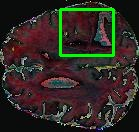

**Tumor detected  by our model(marked in green box)**

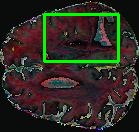

**Done by: Yashwanth S C**